In [3]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


In [ ]:
import sys
sys.path.append('../')

from jwave_utils import get_domain, get_point_medium, get_plane_wave_excitation, get_data

# Simulate data

In [17]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


In [23]:
# define spatial parameters
N = np.array([128, 128]).astype(int) # grid size [grid points]
dx = np.array([element_pitch, element_pitch]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - nelements//2 # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)

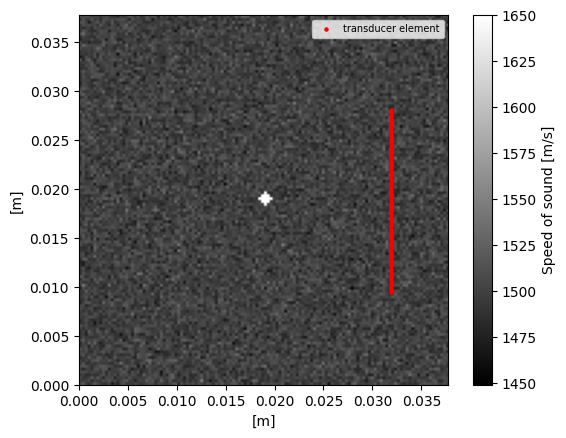

In [25]:
# define jwave medium
domain = get_domain(N, dx)
medium = get_point_medium(domain, rho0=1000, c0=1500, pml_size=pml[0])

ext = [0, N[0]*dx[0], N[1]*dx[1], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(medium.sound_speed.params, cmap='gray', extent=ext)
plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

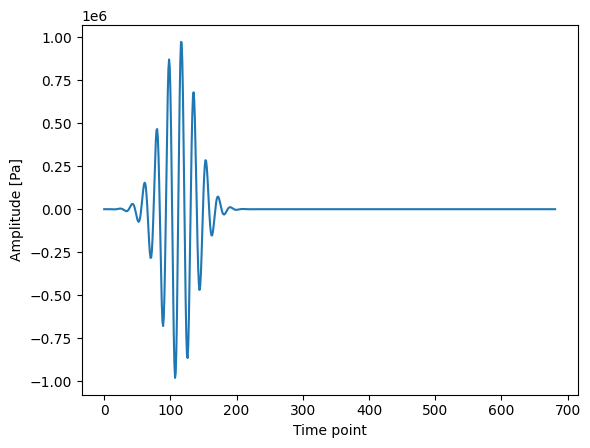

In [27]:
from jwave.geometry import TimeAxis
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
sources = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions)

plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [ ]:
# simulate data using jwave
pressure, data = get_data(medium, time_axis, sources, element_positions)

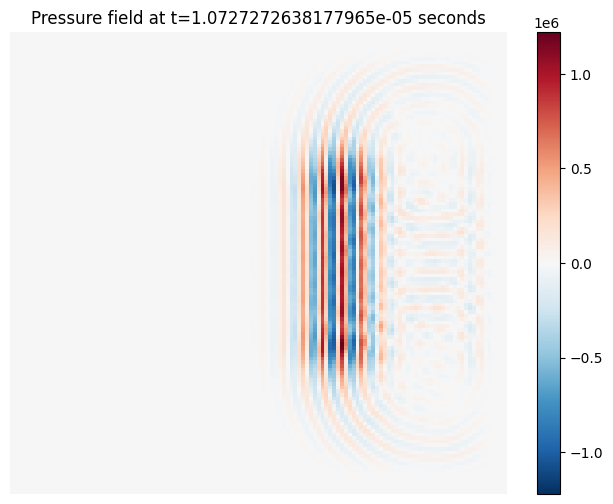

In [28]:
from jwave.utils import show_field

t_idx = 200
show_field(pressure[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

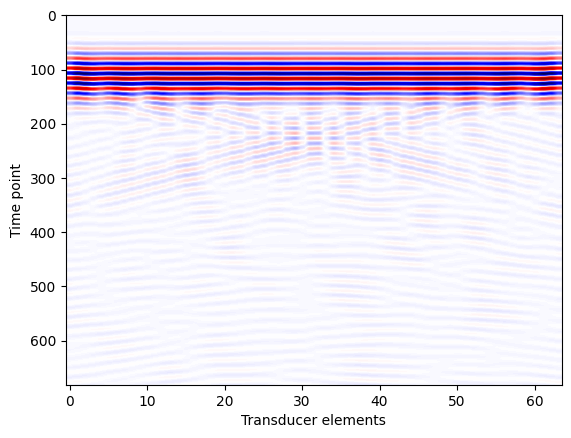

In [29]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

In [ ]:
input_signal = np.stack([s for _ in range(nelements)], axis=1)
output_data = data - input_signal
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Beamforming

In [ ]:
def compute_time_delays_for_point(x1: np.ndarray, x: int, delta_y: int, c: float = c0):
    scaled_y = delta_y * dx[1]
    scaled_dx = (x1 - x) * dx[0]
    return (scaled_y + np.sqrt(scaled_y*scaled_y + scaled_dx * scaled_dx)) / c

element_y = (N[1] - transducer_depth)

T=500

def compute_signal(pt_x, pt_y, time=T):
    delta_y = abs(element_y - pt_y)
    times = time - np.round(compute_time_delays_for_point(element_positions[0], pt_x, delta_y) / time_axis.dt).astype(int)
    # array that looks like [[time1, time2, ...], [32, 33, ...]]
    augmented_times = np.stack([times, element_positions[0]])
    # check the time is within the simulation
    augmented_times = augmented_times[:, 0 < augmented_times[0]]
    augmented_times = augmented_times[:, augmented_times[0] < output_data.shape[0]]
    # check that the sensor index is within bounds
    augmented_times = augmented_times[:, np.abs(augmented_times[1] - pt_x) < delta_y].tolist()
    return np.sum(output_data[augmented_times[0], augmented_times[1]]).item() * time_axis.dt

In [ ]:
def time_t_results(t):
    results = np.array([[compute_signal(i, j, t) for j in range(0, 128)] for i in range(0, 128)])
    return results

res100 = time_t_results(100)
res200 = time_t_results(200)
res300 = time_t_results(300)
res400 = time_t_results(400)
res500 = time_t_results(500)
res600 = time_t_results(600)

In [ ]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(result):
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    # Plotting the heat map
    plt.imshow(result, cmap='viridis', interpolation='nearest')

    # Adding a color bar to show the scale
    plt.colorbar()

    # Display the heat map
    plt.show()
    return result

for i in [res100]: #, res200, res300, res400, res500, res600]:
    postprocess_result(i)